# Neural Network from Scratch

Re-implemented and adapted from [nnfs](https://nnfs.io/)

In [57]:
import numpy as np
import matplotlib.pyplot as plt

## Generate some Data

In [58]:
N = 100
upper = 3
lower = -3
x = np.linspace(lower, upper, N)
x = x.reshape(-1,1)

In [59]:
# y = (120*np.sin(x)+270*np.sin(x-35) + 50*np.sin(x))
y = np.sin(x)
y = x**2

/tmp/ipykernel_3719786/3873877298.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


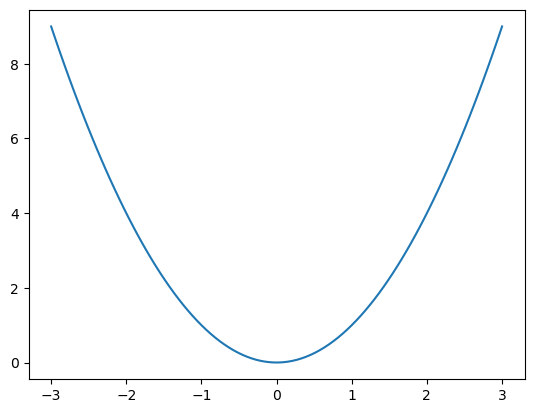

In [60]:
f = plt.figure()
plt.plot(x,y)
f.show()

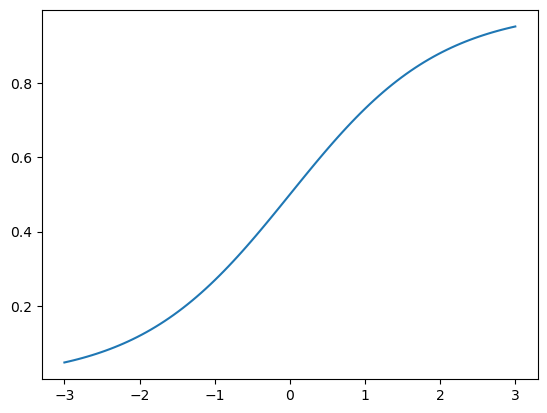

In [61]:
plt.plot(x, 1/(1+np.exp(-x)))

## Define a Network

See p. 210 and 239 of Neural Networks from scratch.

In [62]:
class Dense:
    def __init__(self, inputs, neurons):
        self.weights =  0.1 * np.random.randn(inputs, neurons)
        self.biases = np.zeros((1, neurons))
    def forward(self,inputs):
        self.inputs = inputs # store the inputs to calculage gradient next time
        self.output=np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues) # d/dw(w.x) = x^t Derivative of weights is inputs, multiply this by pre-existing derivative
        self.dbiases = np.sum(dvalues, axis=0, keepdims = True)
        
        # Gradient on values (d/dx)
        self.dinputs = np.dot(dvalues, self.weights.T) # d/dx(w.x) = w^t
        

In [63]:
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs
        
    def backward(self, dvalues):
        # The original variable needs to be modified, so make a copy of it first
        self.dinputs = dvalues.copy()
        
        # Gradient is zero where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [64]:
# Common class for loss
class Loss:
    # Calculates the loss function given observations and prediction
    def calculate(self, output, y):
        
        # Calculate the losses for everything given
        sample_losses = self.forward(output, y)
        
        # Average it
        data_loss = np.mean(sample_losses)
        
        return data_loss

In [65]:
class Loss_SE(Loss):
    
    # Forward Pass
    # Leave Mean and Root to Parent class
    def forward(self, y_pred, y_true):
        return (y_pred-y_true)**2
        
    def backward(self, dvalues, y_pred, y_true):
        self.dinputs = 2*(y_pred-y_true)*dvalues
    

In [66]:
class Optimizer_SGD:
    # Initialize
    def __init__(self, learning_rate=1e-6):
        self.learning_rate = learning_rate
    # Update the parameters
    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases

## Preview the Network

In [67]:
# this one kinda works
class NN_working:
    def __init__(self, insize, outsize, lr=1e-6):
        self.d1   = Dense(insize, outsize)
        self.a1 = ReLu()
        self.l = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        self.d1.forward(x)
        self.a1.forward(self.d1.output)
        return self.a1.output
    def loss(self, y, yhat):
        self.lossval = self.l.calculate(yhat, y)
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self, y):
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.a1.backward(self.l.dinputs)
        self.d1.backward(self.a1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        
    

In [68]:
class NN:
    def __init__(self, insize, h1, outsize, lr=1e-6):
        self.d1   = Dense(insize, h1)
        self.a1 = ReLU()
        self.d2   = Dense(h1, outsize)
        self.l = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        self.d1.forward(x)
        self.a1.forward(self.d1.output)
        self.d2.forward(self.a1.output)
        return self.d2.output
    def loss(self, y, yhat):
        self.lossval = self.l.calculate(yhat, y)
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self, y):
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.d2.backward(self.l.dinputs)
        self.a1.backward(self.d2.dinputs)
        self.d1.backward(self.a1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        self.optimizer.update_params(self.d2)
        
    

In [69]:

net = NN(1, 1000, 1, 1e-6)
yhat = net.forward(x)

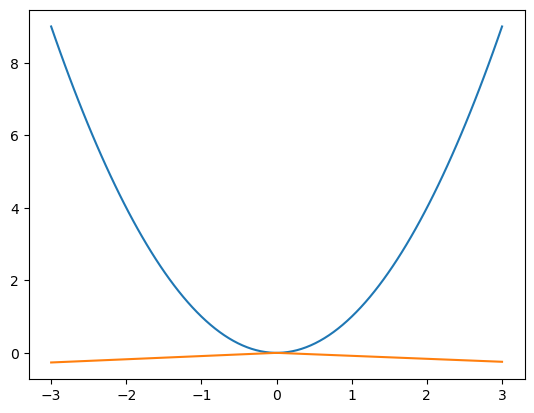

In [70]:
plt.plot(x, y)
plt.plot(x, yhat)

In [71]:
losses = []
EPOCH = 1000
print("|------------------------------------------------------------------------------|")
print(" ", end='', flush=True)
for t in range(EPOCH):
    yhat = net.forward(x)
    losses.append(net.loss(y, yhat))
    net.backward(y)
    net.opt()
    if t in np.floor(np.linspace(start=0, stop=EPOCH, num=78)):
        print("#", end='', flush=True)
    

|------------------------------------------------------------------------------|
 #############################################################################

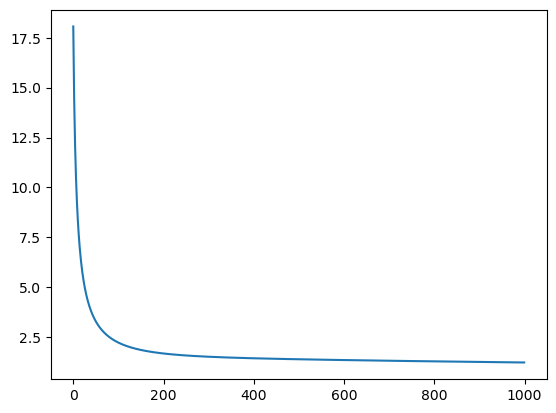

In [72]:
plt.plot(losses)

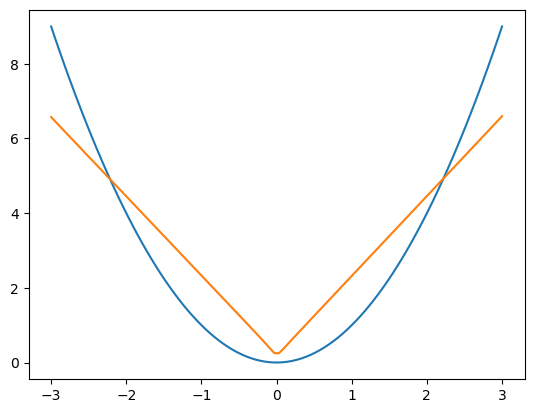

In [73]:
plt.plot(x, y)
plt.plot(x, net.forward(x))

## Sigmoid

Now repeat for Sigmoid

In [74]:
#TODO check this
class Sigmoid:
    def forward(self, inputs):
        e = np.exp
        x = inputs
        self.inputs = inputs
        self.output = np.tanh(x)
        
    def backward(self, dvalues):
        e = np.exp
        x = self.inputs
        self.dinputs = (1-np.tanh(x)**2) * dvalues

class expReLU:
    def __init__(self):
        self.w = 1 # TODO train a weight inside exp

    def forward(self, inputs):
        self.output = np.maximum(0, np.exp(inputs))
        self.inputs = inputs
        
    def backward(self, dvalues):
        # The original variable needs to be modified, so make a copy of it first
        self.dinputs = dvalues.copy()
        
        # Gradient is zero where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        self.dinputs *= np.exp(self.inputs)

In [75]:

class NN:
    def __init__(self, insize, h1, outsize, lr=1e-6):
        self.d1   = Dense(insize, h1)
        self.a1 = Sigmoid()
        self.d2   = Dense(h1, outsize)
        self.l = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        self.d1.forward(x)
        self.a1.forward(self.d1.output)
        self.d2.forward(self.a1.output)
        return self.d2.output
    def loss(self, y, yhat):
        self.lossval = self.l.calculate(yhat, y)
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self, y):
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.d2.backward(self.l.dinputs)
        self.a1.backward(self.d2.dinputs)
        self.d1.backward(self.a1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        self.optimizer.update_params(self.d2)
        


net = NN(1, 1000, 1, 1e-6)
yhat = net.forward(x)
    

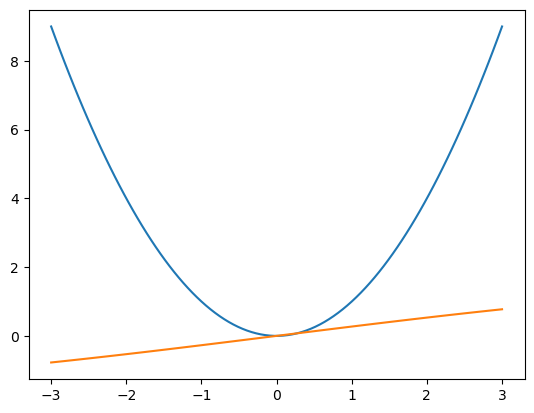

In [76]:

plt.plot(x, y)
plt.plot(x, yhat)
    

In [77]:

losses = []
EPOCH = 1000
print("|------------------------------------------------------------------------------|")
print(" ", end='', flush=True)
for t in range(EPOCH):
    yhat = net.forward(x)
    losses.append(net.loss(y, yhat))
    net.backward(y)
    net.opt()
    if t in np.floor(np.linspace(start=0, stop=EPOCH, num=78)):
        print("#", end='', flush=True)



|------------------------------------------------------------------------------|
 #############################################################################

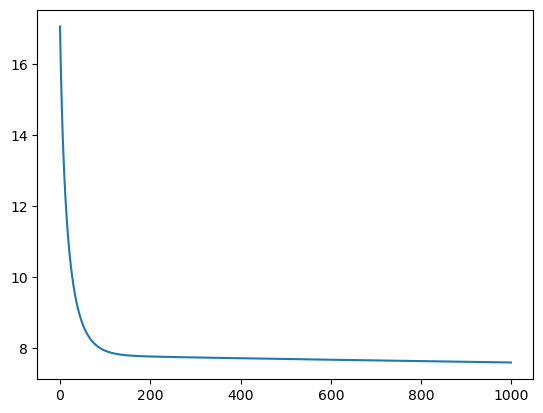

In [78]:

plt.plot(losses)

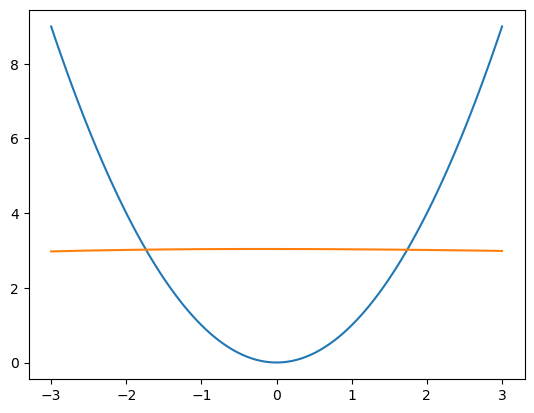

In [79]:

plt.plot(x, y)
plt.plot(x, net.forward(x))

## ReLU With 4 Layers

In [80]:

class NN:
    def __init__(self, insize, h1, h2, h3, outsize, lr=1e-6):
        self.d1 = Dense(insize, h1)
        self.a1 = ReLU()
        self.d2 = Dense(h1, h2)
        self.a2 = ReLU()
        self.d3 = Dense(h2, h3)
        self.a3 = ReLU()
        self.d4 = Dense(h3, outsize)
        self.l  = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        self.d1.forward(x)
        self.a1.forward(self.d1.output)
        self.d2.forward(self.a1.output)
        self.a2.forward(self.d2.output)
        self.d3.forward(self.a2.output)
        self.a3.forward(self.d3.output)
        self.d4.forward(self.a3.output)
        return self.d4.output
    def loss(self, y, yhat):
        self.lossval = self.l.calculate(yhat, y)
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self, y):
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.d4.backward(self.l.dinputs)
        self.a3.backward(self.d4.dinputs)
        self.d3.backward(self.d4.dinputs)
        self.a2.backward(self.d3.dinputs)
        self.d2.backward(self.a2.dinputs)
        self.a1.backward(self.d2.dinputs)
        self.d1.backward(self.a1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        self.optimizer.update_params(self.d2)
        self.optimizer.update_params(self.d3)

    
net = NN(1, 256, 128, 64, 1, lr=1e-6)
yhat = net.forward(x)

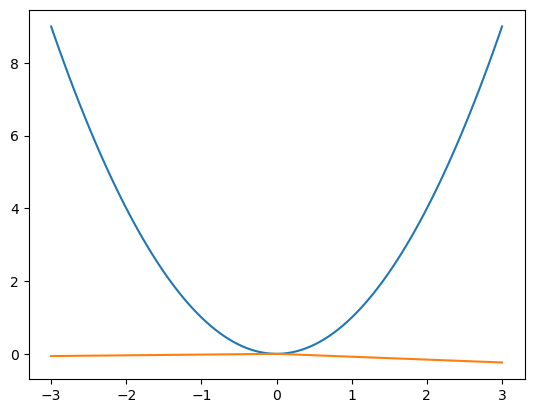

In [81]:

plt.plot(x, y)
plt.plot(x, yhat)

In [82]:

losses = []
EPOCH = 1000
print("|------------------------------------------------------------------------------|")
print(" ", end='', flush=True)
for t in range(EPOCH):
    yhat = net.forward(x)
    losses.append(net.loss(y, yhat))
    net.backward(y)
    net.opt()
    if t in np.floor(np.linspace(start=0, stop=EPOCH, num=78)):
        print("#", end='', flush=True)

|------------------------------------------------------------------------------|
 #############################################################################

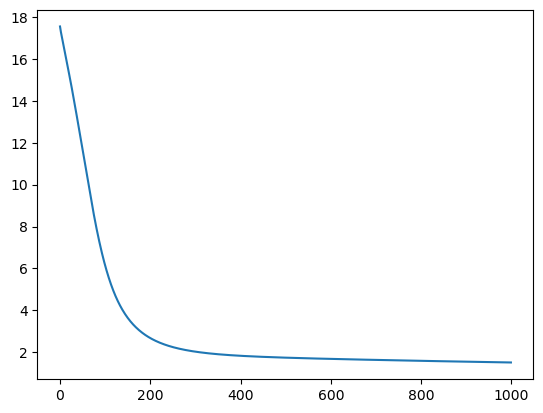

In [83]:

plt.plot(losses)

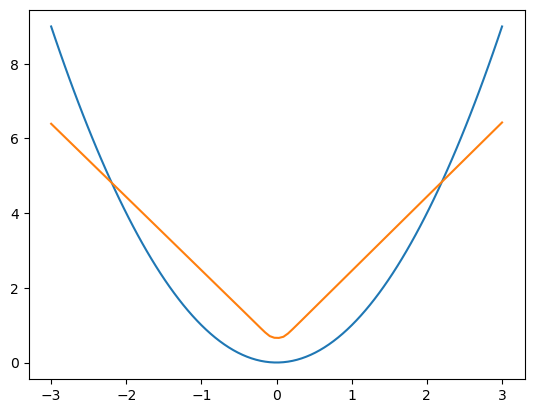

In [84]:

plt.plot(x, y)
plt.plot(x, net.forward(x))

## Sigmoid Activation with 4 Layers

In [85]:

class NN:
    def __init__(self, insize, h1, h2, outsize, lr=1e-6):
        self.d1   = Dense(insize, h1)
        self.a1 = ReLU()
        self.d2   = Dense(h1, h2)
        self.a2 = Sigmoid()
        self.d3 = Dense(h2, outsize)
        self.l = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        self.d1.forward(x)
        self.a1.forward(self.d1.output)
        self.d2.forward(self.a1.output)
        self.a2.forward(self.d2.output)
        self.d3.forward(self.a2.output)
        return self.d3.output
    def loss(self, y, yhat):
        self.lossval = self.l.calculate(yhat, y)
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self, y):
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.d3.backward(self.l.dinputs)
        self.a2.backward(self.d3.dinputs)
        self.d2.backward(self.a2.dinputs)
        self.a1.backward(self.d2.dinputs)
        self.d1.backward(self.a1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        self.optimizer.update_params(self.d2)

    
net = NN(1, 1024,512, 1, 1e-6)
yhat = net.forward(x)

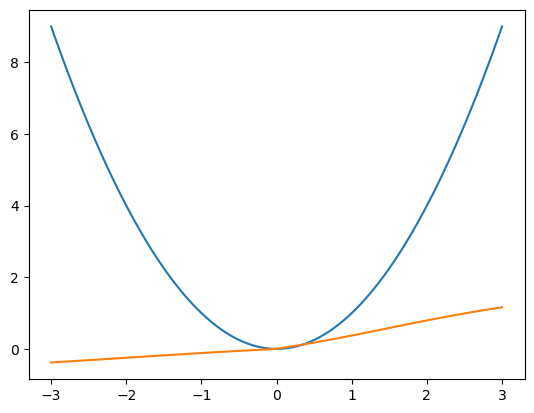

In [86]:

plt.plot(x, y)
plt.plot(x, yhat)

In [87]:

losses = []
EPOCH = 1000
print("|------------------------------------------------------------------------------|")
print(" ", end='', flush=True)
for t in range(EPOCH):
    yhat = net.forward(x)
    losses.append(net.loss(y, yhat))
    net.backward(y)
    net.opt()

    if t in np.floor(np.linspace(start=0, stop=EPOCH, num=78)):
        print("#", end='', flush=True)

|------------------------------------------------------------------------------|
 #############################################################################

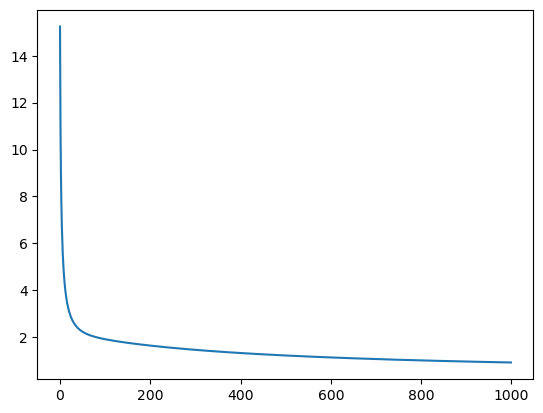

In [88]:

plt.plot(losses)

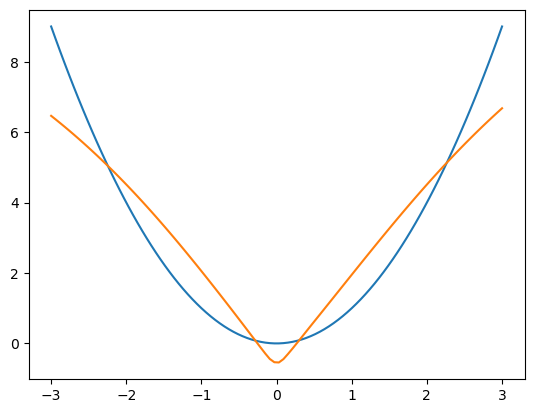

In [89]:

plt.plot(x, y)
plt.plot(x, net.forward(x))